# Did not train

In [26]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW, Adam

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

## Load Config Object from .yaml file

### Modify the config

In [4]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [5]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

# Hiera

In [10]:
import torch
from hiera import Hiera
tiny_hiera = Hiera(input_size=(16,144, 256),
                     num_heads=1, 
                     stages=(4, 4), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(2, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)
#tiny_hiera = torch.compile(tiny_hiera).cuda().to(torch.bfloat16);
tiny_hiera = tiny_hiera.cuda().to(torch.bfloat16);

In [11]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
out = tiny_hiera(example_in, return_intermediates=True);
features = out[-1][-1]
features.shape

torch.Size([8, 4, 18, 32, 192])

In [12]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = tiny_hiera(example_in, return_intermediates=True);

100% 100/100 [00:01<00:00, 89.16it/s]


In [10]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos, return_intermediates=True);
        if i > 200:
            break

201it [00:13, 14.63it/s]


In [18]:
32*15*16

7680

In [13]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        out_features: int = 1,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.out_features = out_features
        self.init_std = init_std

        self.query = nn.Parameter(
            torch.empty(1, 4, unique_ids, 32, **factory_kwargs)
        )
        self.weight = nn.Parameter(
            torch.empty(unique_ids, in_features, out_features, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, out_features, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.weight,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

In [14]:
class ELU1(nn.Module):
    """
    Adapted from `NeuralPredictors <https://github.com/sinzlab/neuralpredictors/blob/main/neuralpredictors/layers/activations.py>`__.
    
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:
    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x, inplace=False, eps=0.0):
        return F.elu(x, inplace=inplace) + 1.0 + eps

In [15]:
class MouseHieraSmall(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 t=16,
                 dim=512,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.neuron_proj = nn.Linear(dim_head * num_heads, t, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = ELU1()
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, in_features=dim_head*num_heads, out_features=1)
    
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        seq_len = t*h*w
        x = x.view(b, -1, d)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2]
        q = q.tile(b, 1, 1, 1)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + r.readout[key].bias
        o = F.elu(o, inplace=True) + 1.0
        return o

In [19]:
backbone_dim = features[-1][-1].shape[-1]
r = MouseHieraSmall(tiny_hiera, train_dl, 16, backbone_dim, dim_head=32,num_heads=4)
#opt_r = torch.compile(r, )
opt_r = r

In [20]:
torch.set_float32_matmul_precision('high')
opt_r.backbone.to(torch.bfloat16).cuda();
opt_r = opt_r.train().to(torch.bfloat16).cuda()
opt_r = opt_r.cuda().to(torch.bfloat16)
opt_r = torch.compile(r).cuda().to(torch.bfloat16)

In [21]:
k, b = next(iter(train_dl))
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
out = opt_r(videos, k);

In [31]:
criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = Adam(opt_r.parameters(), lr=1e-2, fused=True)
import pytorch_warmup as warmup
from torch.amp import autocast
warmup_scheduler = warmup.UntunedLinearWarmup(opt, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 1e6, eta_min=1e-7)


In [23]:
opt.param_groups[0]['lr']

2.5012506253126564e-06

In [41]:
len(losses) / (  2000)

60.6

In [ ]:
losses, corrs, lrs = [], [], []
for train_loop in range(10):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
            print(opt.param_groups[0]['lr'])
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:09,  9.57s/it]

0.005579711551606921
5.00250125061297e-06


8it [01:57, 15.57s/it]W1016 01:30:46.333000 79721 torch/_dynamo/convert_frame.py:844] [0/9] torch._dynamo hit config.cache_size_limit (8)
W1016 01:30:46.333000 79721 torch/_dynamo/convert_frame.py:844] [0/9]    function: 'forward' (/tmp/ipykernel_79721/1780887616.py:22)
W1016 01:30:46.333000 79721 torch/_dynamo/convert_frame.py:844] [0/9]    last reason: 0/1: L['key'] == '29513-3-5'                                     
W1016 01:30:46.333000 79721 torch/_dynamo/convert_frame.py:844] [0/9] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1016 01:30:46.333000 79721 torch/_dynamo/convert_frame.py:844] [0/9] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
101it [02:20,  3.77it/s]

0.00919894331606866
0.0002551275573604695


201it [02:44,  3.68it/s]

0.02251067545265528
0.00050525257594782


301it [03:08,  3.79it/s]

0.05403778898328862
0.0007553775199838818


401it [03:33,  3.72it/s]

0.09669598725326022
0.0010055023524398825


501it [03:57,  3.68it/s]

0.11596272170823656
0.0012556270362870715


601it [04:21,  3.77it/s]

0.11589332920961666
0.00150575153449672


701it [04:45,  3.73it/s]

0.11813537750705845
0.0017558758100401296


801it [05:10,  3.72it/s]

0.12525221595391053
0.0020059998258886423


901it [05:34,  3.86it/s]

0.1161736425707978
0.0022561235450136376


1001it [05:58,  3.66it/s]

0.13359187884293655
0.0025062469303865466


1101it [06:22,  3.68it/s]

0.11314559552844818
0.0027563699449788576


1201it [06:47,  3.72it/s]

0.11733701065331292
0.003006492551762117


1301it [07:11,  3.65it/s]

0.12253864357093018
0.003256614713707936


1401it [07:35,  3.82it/s]

0.12116844494106062
0.0035067363937880004


1501it [07:59,  3.78it/s]

0.11912868267282291
0.003756857554974079


1601it [08:23,  3.64it/s]

0.12034895162775874
0.004006978160238024


1701it [08:48,  3.76it/s]

0.11411591021876782
0.004257098172551774


1801it [09:12,  3.82it/s]

0.1233722491514835
0.00450721755488737


1901it [09:36,  3.69it/s]

0.1200793345683435
0.004757336270216957


2001it [10:00,  3.68it/s]

0.11752488769872718
0.00499995060376827


2020it [10:05,  3.34it/s]
1it [00:00,  2.90it/s]

0.12130077274362781
0.0049999496114059945


101it [00:24,  3.78it/s]

0.12005088844833378
0.004999944501556588


201it [00:48,  3.82it/s]

0.11957448534624435
0.004999939144977486


301it [01:12,  3.76it/s]

0.13538768288168226
0.004999933541669214


401it [01:36,  3.75it/s]

0.11757342189769178
0.004999927691632329


501it [02:01,  3.85it/s]

0.12648637603514146
0.004999921594867411


601it [02:25,  3.75it/s]

0.13767133890361938
0.0049999152513750525


701it [02:49,  3.71it/s]

0.13500411216082142
0.0049999086611558835


801it [03:13,  3.86it/s]

0.1287557560300004
0.0049999018242105585


901it [03:37,  3.79it/s]

0.12947480833977593
0.0049998947405397514


1001it [04:01,  3.82it/s]

0.13409157111310727
0.0049998874101441606


1101it [04:25,  3.83it/s]

0.13079893815230986
0.0049998798330245136


1201it [04:49,  3.71it/s]

0.12993643142725805
0.00499987200918155


1301it [05:14,  3.71it/s]

0.12409956628434494
0.004999863938616047


1401it [05:38,  3.76it/s]

0.12980006584245257
0.004999855621328798


1501it [06:02,  3.76it/s]

0.14003855712793034
0.004999847057320627


1601it [06:26,  3.81it/s]

0.13646767180987604
0.004999838246592377


1701it [06:51,  3.80it/s]

0.12212127800782915
0.004999829189144913


1801it [07:15,  3.79it/s]

0.13720721845529943
0.004999819884979136


1901it [07:39,  3.77it/s]

0.1402198319530697
0.004999810334095959


2001it [08:03,  3.82it/s]

0.13505018220363638
0.004999800536496333


2020it [08:07,  4.14it/s]
1it [00:00,  2.81it/s]

0.14024822596335984
0.004999798547370517


101it [00:24,  3.84it/s]

0.13656813332706613
0.004999788453712426


201it [00:48,  3.79it/s]

0.12796489411615186
0.00499977811334004


301it [01:12,  3.74it/s]

0.1342345117756375
0.004999767526254377


401it [01:36,  3.69it/s]

0.13473482957086688
0.004999756692456486


501it [02:01,  3.63it/s]

0.14232133828640117
0.004999745611947437


601it [02:25,  3.68it/s]

0.14679976885176396
0.004999734284728321


701it [02:49,  3.87it/s]

0.1289123128024346
0.004999722710800259


801it [03:13,  3.64it/s]

0.12891030157871336
0.004999710890164392


901it [03:37,  3.76it/s]

0.14092381848507898
0.004999698822821885


1001it [04:01,  3.86it/s]

0.13206338636142895
0.004999686508773929


1101it [04:25,  3.80it/s]

0.13319223850582623
0.004999673948021737


1201it [04:49,  3.81it/s]

0.1426552250585711
0.00499966114056655


1301it [05:13,  3.72it/s]

0.1352838823246611
0.00499964808640964


1401it [05:38,  3.65it/s]

0.13962732825444943
0.004999634785552285


1501it [06:02,  3.77it/s]

0.1311690446595191
0.004999621237995804


1601it [06:26,  3.84it/s]

0.12270849554157076
0.004999607443741532


1701it [06:50,  3.80it/s]

0.14087348465963317
0.004999593402790828


1801it [07:14,  3.61it/s]

0.13785854697825234
0.004999579115145082


1901it [07:38,  3.87it/s]

0.1291272316276113
0.004999564580805702


2001it [08:02,  3.80it/s]

0.14643394498800996
0.004999549799774132


2020it [08:07,  4.15it/s]
1it [00:00,  3.09it/s]

0.1316824915767522
0.004999546813964883


101it [00:24,  3.65it/s]

0.14126648396964758
0.0049995317369045935


201it [00:48,  3.81it/s]

0.14589895002964137
0.004999516413155346


301it [01:12,  3.86it/s]

0.13288157786734328
0.004999500842718659


401it [01:36,  3.77it/s]

0.13972362540638258
0.004999485025596064


501it [02:00,  3.81it/s]

0.15956843412839405
0.00499946896178912


601it [02:24,  3.79it/s]

0.1331247468497308
0.00499945265129941


701it [02:48,  3.68it/s]

0.1286705366898894
0.004999436094128548


801it [03:13,  3.82it/s]

0.1327178271991951
0.0049994192902781745


901it [03:37,  3.75it/s]

0.14191055965372915
0.0049994022397499395


1001it [04:01,  3.81it/s]

0.13937549811027436
0.004999384942545526


1101it [04:25,  3.76it/s]

0.13638728997814134
0.00499936739866664


1201it [04:49,  3.71it/s]

0.1384631904822549
0.004999349608115019


1301it [05:13,  3.77it/s]

0.13983240809271447
0.0049993315708924185


1401it [05:37,  3.82it/s]

0.1407194767747605
0.004999313287000616


1501it [06:01,  3.79it/s]

0.14274633174464943
0.004999294756441417


1601it [06:25,  3.79it/s]

0.14139289409201805
0.004999275979216648


1701it [06:49,  3.80it/s]

0.13187605480336867
0.004999256955328162


1801it [07:14,  3.88it/s]

0.13105566316419667
0.004999237684777835


1901it [07:38,  3.73it/s]

0.1469978497106433
0.0049992181675675715


2001it [08:02,  3.82it/s]

0.1402749838446369
0.004999198403699297


2020it [08:06,  4.15it/s]
1it [00:00,  2.64it/s]

0.13667272006118672
0.004999194421326853


101it [00:24,  3.83it/s]

0.13646913317904266
0.00499917436147155


201it [00:48,  3.79it/s]

0.13943820368520746
0.0049991540549625645


301it [01:12,  3.81it/s]

0.14838114247773881
0.004999133501801893


401it [01:36,  3.68it/s]

0.14264821509997797
0.004999112701991566


501it [02:00,  3.87it/s]

0.1362000873436119
0.004999091655533642


601it [02:24,  3.67it/s]

0.14348565208838782
0.004999070362430194


701it [02:48,  3.83it/s]

0.1420423213740382
0.0049990488226833284


801it [03:13,  3.75it/s]

0.14820609942635893
0.0049990270362951636


901it [03:37,  3.79it/s]

0.13183521593307965
0.004999005003267851


1001it [04:01,  3.67it/s]

0.15488880244459874
0.004998982723603567


1101it [04:25,  3.83it/s]

0.13642630011489354
0.004998960197304512


1201it [04:49,  3.71it/s]

0.1424111179402495
0.004998937424372911


1301it [05:13,  3.76it/s]

0.14083792554187563
0.0049989144048110095


1401it [05:37,  3.86it/s]

0.13237610250780285
0.004998891138621082


1501it [06:01,  3.74it/s]

0.15045456880021923
0.0049988676258054185


1601it [06:25,  3.59it/s]

0.13438184644039122
0.0049988438663663435


1701it [06:50,  3.86it/s]

0.14796744477309615
0.004998819860306198


1801it [07:14,  3.72it/s]

0.14011549797572567
0.004998795607627352


1901it [07:38,  3.84it/s]

0.12789978067062222
0.004998771108332204


2001it [08:02,  3.72it/s]

0.15046049022723215
0.004998746362423166


2020it [08:06,  4.15it/s]
1it [00:00,  3.11it/s]

0.14157779440200252
0.004998741383647909


101it [00:24,  3.78it/s]

0.1445475164275851
0.004998716341805438


201it [00:48,  3.80it/s]

0.14315523969238655
0.004998691053354478


301it [01:12,  3.77it/s]

0.147610447313229
0.00499866551829754


401it [01:36,  3.88it/s]

0.15983982341327085
0.004998639736637128


501it [02:00,  3.70it/s]

0.1621065013511246
0.004998613708375804


504it [02:01,  4.05it/s]

In [35]:
len(losses)

121200

In [ ]:
for train_loop in range(100):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:00,  3.27it/s]

0.27168718965049504


101it [00:24,  3.82it/s]

0.2751727973399908


201it [00:48,  3.75it/s]

0.263926778163607


301it [01:12,  3.82it/s]

0.2663187322026008


401it [01:36,  3.73it/s]

0.2645397656490973


501it [02:00,  3.82it/s]

0.2861726362460161


601it [02:24,  3.73it/s]

0.28580948264396216


701it [02:48,  3.83it/s]

0.2701857317417862


801it [03:12,  3.83it/s]

0.27006208484098393


901it [03:36,  3.83it/s]

0.26799058215597193


1001it [04:00,  3.78it/s]

0.2722806036221415


1101it [04:24,  3.83it/s]

0.27451158801149317


1201it [04:48,  3.75it/s]

0.296098101794598


1301it [05:12,  3.83it/s]

0.26590935823773665


1401it [05:36,  3.83it/s]

0.2643687023968096


1501it [06:00,  3.81it/s]

0.2774193644363052


1601it [06:24,  3.82it/s]

0.2734014990981337


1701it [06:48,  3.81it/s]

0.263998874634109


1801it [07:12,  3.80it/s]

0.2680346769967789


1901it [07:36,  3.83it/s]

0.26536336856990245


2001it [08:00,  3.76it/s]

0.26972732681410144


2020it [08:05,  4.16it/s]
1it [00:00,  3.27it/s]

0.2654153503209811


101it [00:24,  3.89it/s]

0.2590541034583764


201it [00:48,  3.89it/s]

0.27950698173691974


301it [01:12,  3.90it/s]

0.2725092356627529


401it [01:36,  3.90it/s]

0.2772662353702632


501it [02:00,  3.84it/s]

0.2728395927157427


601it [02:24,  3.90it/s]

0.27771024200528227


701it [02:48,  3.85it/s]

0.25722339438804526


801it [03:12,  3.90it/s]

0.27911494093833417


901it [03:36,  3.87it/s]

0.28671782058028533


1001it [04:00,  3.86it/s]

0.27461124943478177


1101it [04:24,  3.85it/s]

0.2569307028666303


1201it [04:48,  3.90it/s]

0.28499140063087197


1301it [05:12,  3.90it/s]

0.25844735587387957


1401it [05:36,  3.90it/s]

0.2777321628484418


1501it [06:00,  3.89it/s]

0.30453867144868846


1601it [06:24,  3.89it/s]

0.27763028904880227


1701it [06:48,  3.90it/s]

0.28382832416077297


1801it [07:12,  3.88it/s]

0.2641134960283218


1901it [07:36,  3.83it/s]

0.2694789956507372


2001it [08:00,  3.91it/s]

0.2390510372264376


2020it [08:04,  4.17it/s]
1it [00:00,  3.25it/s]

0.28401686146596644


101it [00:24,  3.87it/s]

0.2844928122732722


201it [00:48,  3.85it/s]

0.2768630785009039


301it [01:12,  3.81it/s]

0.2736201610895918


401it [01:36,  3.77it/s]

0.2852340346409566


501it [02:00,  3.87it/s]

0.26179958969580913


601it [02:24,  3.84it/s]

0.28838295559404203


701it [02:48,  3.86it/s]

0.28171627380377806


801it [03:12,  3.87it/s]

0.26540244754547204


901it [03:36,  3.86it/s]

0.27188698385587895


1001it [04:00,  3.80it/s]

0.26780593449198775


1101it [04:24,  3.85it/s]

0.2969200169391755


1201it [04:48,  3.87it/s]

0.26711911242025116


1301it [05:12,  3.86it/s]

0.2564683066516287


1401it [05:36,  3.83it/s]

0.26105549128851974


1501it [06:00,  3.81it/s]

0.28033377984518637


1601it [06:24,  3.79it/s]

0.2789926003306469


1701it [06:49,  3.86it/s]

0.2699705036223592


1720it [06:53,  4.24it/s]

In [90]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.sample_stride=16
cfg.dataset.modality_config.screen.valid_condition = {"tier": "oracle"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [91]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths[4:5], cfg)

In [92]:
targets, predictions = [],[]
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        out = opt_r(videos, k);
        predictions.append(out.transpose(1,2).to(torch.float32).cpu().numpy())
        targets.append(responses.to(torch.float32).cpu().numpy())

7it [00:01,  3.85it/s]


In [99]:
r1 = np.vstack(np.vstack(predictions))
r2 = np.vstack(np.vstack(targets))
np.stack(cs).mean()

np.float64(0.08530636440130607)

In [98]:
n=50
#plt.scatter(r1[:,n], r2[:,n])

In [96]:
cs = []
for n in range(5000):
    c =  np.corrcoef(r1[...,n].flatten(), r2[...,n].flatten(), )[0,1]
    cs.append(c)

np.float64(0.08530636440130607)

## Overfitting

In [ ]:
plt.plot(corrs)

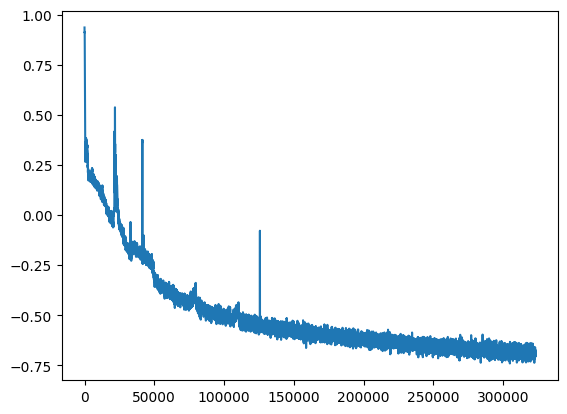

In [48]:
plt.plot(np.convolve(losses, np.ones((100,)), "valid")/100, )

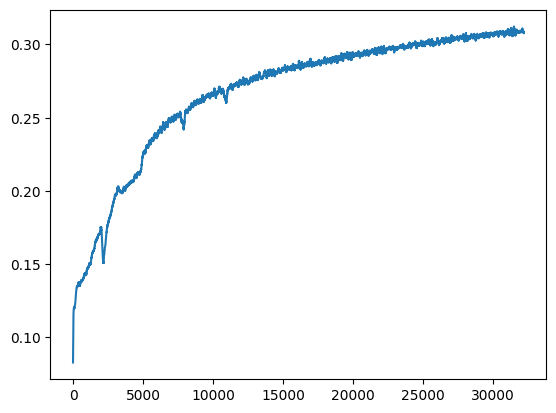

In [49]:
plt.plot(np.convolve(corrs, np.ones((100,)), "valid")/100, )

In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

7it [00:14,  2.00s/it]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:168: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
8it [00:22,  4.01s/it]W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_20839/2467812288.py:21)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch

In [25]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:09, 22.31it/s]


In [106]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:08, 22.55it/s]


In [30]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos,);
        if i > 200:
            break

201it [00:03, 52.64it/s]


In [ ]:
opt.zero_grad()


In [193]:
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)

In [194]:
from torch.amp import autocast

In [182]:
opt_r.to(torch.bfloat16);

In [183]:
with autocast(device_type='cuda', dtype=torch.float16):
    out = opt_r(videos, k);


In [57]:
out.shape

torch.Size([8, 7495, 16])

In [58]:
loss = criteria(out.transpose(1,2), responses)

In [59]:
loss.backward()

In [61]:
opt.step()

In [63]:
opt.zero_grad()

In [65]:
loss.shape

torch.Size([])

In [186]:
videos.shape

torch.Size([8, 1, 16, 144, 256])

In [196]:
opt_r = opt_r.to(torch.bfloat16)

In [197]:
out = opt_r(videos, k);

In [ ]:
out = opt_r(videos, k);

In [ ]:
losses = []
for _ in tqdm(range(1000)):
    #with autocast(device_type='cuda', dtype=torch.bfloat16):
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    out = opt_r(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

 58% 576/1000 [01:24<01:01,  6.84it/s]

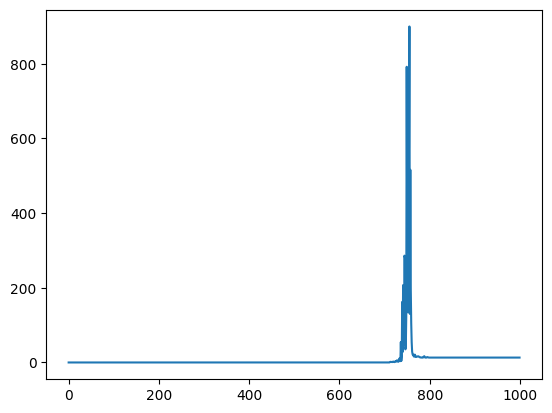

In [218]:
plt.plot(losses)

In [141]:
out.shape

torch.Size([8, 7495, 16])

In [142]:
responses.shape

torch.Size([8, 16, 7495])

In [51]:
neuron=66

0.12096827660364878

In [38]:
out.shape

torch.Size([8, 7495, 16])

In [ ]:
for batch_no, (data_key, data) in tqdm(enumerate(LongCycler(dataloaders["train"])), total=n_iterations,
                                       desc="Epoch {}".format(epoch)):

    loss = full_objective(model, dataloaders["train"], data_key, *data)
    # loss = torch.sum(loss)
    loss.backward()

In [33]:
full_out.shape

torch.Size([8, 7671, 16])

In [ ]:
r.readout["29513-3-5"].bias.shape

In [97]:
full_out = rearrange(full_out, 'b (n t) c -> b t n c', n=7671, t=16)

In [49]:
full_out.shape

torch.Size([8, 16, 7671, 384])

In [50]:
w = r.readout["29513-3-5"].weight

In [51]:
w.shape

torch.Size([7671, 256, 1])

In [54]:
torch.einsum("btni, njr->bnt", full_out, w, )

torch.Size([8, 7671, 16])

In [93]:
full_out.shape

torch.Size([8, 7671, 256])

In [75]:
torch.isnan(full_out).sum()

tensor(960416, device='cuda:0')

In [37]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.38it/s]


In [39]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.43it/s]


In [43]:
for i in tqdm(range(100)):
    r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 103.98it/s]


In [29]:
import torch
n_params=0
for n, p in r.readout.named_parameters():
    print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

29513-3-5.query torch.Size([1, 8, 7671, 32]) 1963776
29513-3-5.weight torch.Size([7671, 256, 1]) 1963776
29513-3-5.bias torch.Size([1, 7671, 1]) 7671
29514-2-9.query torch.Size([1, 8, 7495, 32]) 1918720
29514-2-9.weight torch.Size([7495, 256, 1]) 1918720
29514-2-9.bias torch.Size([1, 7495, 1]) 7495
29755-2-8.query torch.Size([1, 8, 8122, 32]) 2079232
29755-2-8.weight torch.Size([8122, 256, 1]) 2079232
29755-2-8.bias torch.Size([1, 8122, 1]) 8122
29647-19-8.query torch.Size([1, 8, 8202, 32]) 2099712
29647-19-8.weight torch.Size([8202, 256, 1]) 2099712
29647-19-8.bias torch.Size([1, 8202, 1]) 8202
29156-11-10.query torch.Size([1, 8, 7440, 32]) 1904640
29156-11-10.weight torch.Size([7440, 256, 1]) 1904640
29156-11-10.bias torch.Size([1, 7440, 1]) 7440
29623-4-9.query torch.Size([1, 8, 7908, 32]) 2024448
29623-4-9.weight torch.Size([7908, 256, 1]) 2024448
29623-4-9.bias torch.Size([1, 7908, 1]) 7908
29515-10-12.query torch.Size([1, 8, 7863, 32]) 2012928
29515-10-12.weight torch.Size([7863,

In [23]:
full_out.shape

torch.Size([8, 7671, 256])

In [38]:
30684/16

1917.75

In [ ]:
30684

In [35]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

torch.Size([8, 4, 18, 16, 384])
torch.Size([8, 1152, 256])
torch.Size([8, 1152, 256])
torch.Size([32, 8, 7671, 32])
torch.Size([8, 8, 1152, 32])
torch.Size([8, 8, 1152, 32])


In [42]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

100% 100/100 [00:00<00:00, 110.38it/s]


In [20]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        tiny_hiera(example_in);

100% 1000/1000 [00:21<00:00, 46.31it/s]


In [11]:
24*32*16

12288

In [22]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        #tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:17, 17.03it/s]


In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:22, 13.28it/s]


In [25]:
import torch
n_params=0
for n, p in tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4891336


In [2]:
import hiera

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from hiera import Hiera


In [3]:
hiera

<module 'hiera' from '/usr/local/lib/python3.10/dist-packages/hiera/__init__.py'>

In [1]:
from hiera import Hiera
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k_ft_in1k")  # mae pt then in1k ft'd model
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k") # just mae pt, no ft

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Hiera.from_pretrained("facebook/hiera_tiny_224.mae_in1k") # just mae pt, no ft

In [3]:

import torch
from hiera import Hiera
my_tiny_hiera = Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2))

In [4]:
my_cut_hiera = Hiera(input_size=(16,144, 144),
                     num_heads=1, 
                     stages=(1, 2, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 7, 7),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

In [5]:
my_cut_hiera.eval().cuda().to(torch.bfloat16);

In [6]:
from tqdm import tqdm

In [11]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        my_cut_hiera(example_in);

 19% 193/1000 [00:15<01:06, 12.07it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f167ca8b370>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [125]:
out = my_cut_hiera(torch.ones(1,1,16,144,144).cuda(), return_intermediates=True)

In [122]:
(out[1])[1].shape

torch.Size([1, 8, 18, 18, 192])

In [81]:
36*4

144

In [69]:
my_cut_hiera.head.projection.weight.shape

torch.Size([1000, 384])

In [75]:
import numpy as np

In [76]:
np.sqrt(384)

np.float64(19.595917942265423)

In [40]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(413)forward()
    411             else None,
    412         )
--> 413         x = x + self.get_pos_embed()
    414         x = self.unroll(x)
    415 



ipdb>  x.shape


torch.Size([1, 3888, 96])


ipdb>  self.get_pos_embed().shape


torch.Size([1, 10368, 96])


ipdb>  q


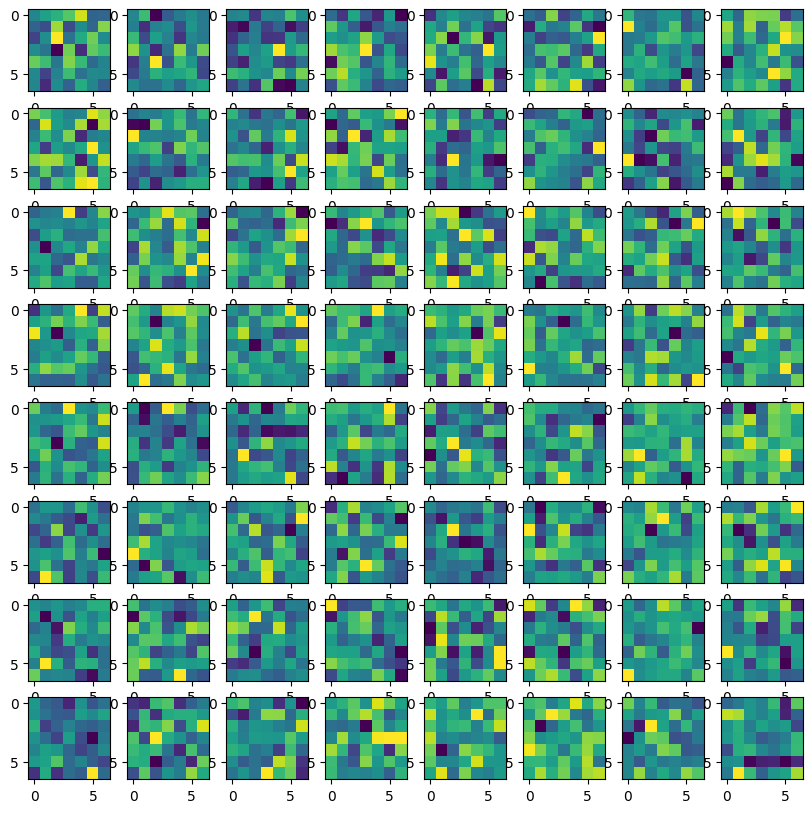

In [83]:
fig, axs = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,0].cpu().numpy())

In [2]:
import torch

In [7]:
some_weights = torch.load("mae_hiera_tiny_224.pth")
my_cut_hiera.load_state_dict(some_weights["model_state"], strict=False)


/tmp/ipykernel_248295/1124240724.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  some_weights = torch.load("mae_hiera_tiny_224.pth")


RuntimeError: Error(s) in loading state_dict for Hiera:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 3136, 96]) from checkpoint, the shape in current model is torch.Size([1, 2304, 96]).

In [ ]:
fig, axs = plt.subplots(8,12, figsize=(12,8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,2].cpu().numpy(), cmap="hot")
    ax.axis("off")

In [8]:
n_params=0
for n, p in my_tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [9]:
n_params=0
for n, p in model.named_parameters():
    print#(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [10]:
n_params=0
for n, p in my_cut_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4987336


In [11]:
my_cut_hiera.to("cuda", torch.bfloat16);
my_tiny_hiera.to("cuda", torch.bfloat16);


In [12]:
from tqdm import tqdm

In [13]:
with torch.no_grad():
    for i in tqdm(range(100)):
        my_cut_hiera(torch.ones(500,3,256,144).to("cuda", torch.bfloat16));

100% 100/100 [00:16<00:00,  6.09it/s]


In [15]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.48it/s]


In [16]:
my_tiny_hiera = torch.compile(my_tiny_hiera,)

In [9]:
my_tiny_hiera.to("cuda", torch.bfloat16);
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
out = my_tiny_hiera(example, );

In [19]:
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.60it/s]


In [21]:
torch.set_float32_matmul_precision('high')
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.64it/s]


In [22]:
torch.set_float32_matmul_precision('medium')

In [24]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)


100% 100/100 [00:13<00:00,  7.63it/s]


In [30]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [32]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [36]:
torch.backends.cuda.enable_flash_sdp(False)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.46it/s]


In [37]:
torch.backends.cuda.enable_flash_sdp(True)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.37it/s]


In [4]:
import torch

In [15]:
example.shape


torch.Size([500, 3, 224, 224])

In [5]:
torch.__version__

'2.6.0.dev20240913+cu121'

In [14]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(100)forward()
     98         if hasattr(F, "scaled_dot_product_attention"):
     99             # Note: the original paper did *not* use SDPA, it's a free boost!
--> 100             x = F.scaled_dot_product_attention(q, k, v)
    101         else:
    102             attn = (q * self.scale) @ k.transpose(-1, -2)



ipdb>  F


<module 'torch.nn.functional' from '/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py'>


ipdb>  k.shape


torch.Size([500, 1, 49, 64, 96])


ipdb>  q


In [21]:
from tqdm import tqdm
torch.set_float32_matmul_precision('medium')
from torch.nn.attention import SDPBackend, sdpa_kernel
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(torch.ones(10,3,224,224).to("cuda", torch.bfloat16), );

  0% 0/100 [00:00<?, ?it/s]


RuntimeError: No available kernel. Aborting execution.

In [2]:
128*8*3*224*224*2 / 1e9

0.308281344

In [ ]:
! 

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))